<a href="https://colab.research.google.com/github/cod3astro/kaggle_ML_competition/blob/main/loan_payback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
train = pd.read_csv('train.csv', index_col='id')
target = train['loan_paid_back']
train.drop(columns=['loan_paid_back'], inplace=True)
train['is_train'] = 1 # Mark training data

test = pd.read_csv('test.csv', index_col='id')
test['is_train'] = 0 # Mark test data

df = pd.concat([train, test])
df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,is_train
id,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,1
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1


In [14]:
df.shape

(848563, 12)

In [15]:
df.isnull().any().any()

np.False_

In [13]:
df.describe()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,is_train
count,848563.000000,848563.000000,848563.000000,848563.000000,848563.000000,848563.000000
mean,48218.466144,0.120662,680.952514,15019.234385,12.355139,0.700000
std,26714.243232,0.068576,55.484775,6925.217352,2.011555,0.458258
min,6002.430000,0.011000,395.000000,500.050000,3.200000,0.000000
25%,27939.785000,0.072000,646.000000,10275.010000,10.990000,0.000000
50%,46552.600000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,61003.900000,0.156000,719.000000,18851.520000,13.680000,1.000000
max,393381.740000,0.627000,849.000000,48959.950000,21.290000,1.000000


In [12]:
df.describe(include='object')

,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
count,848563,848563,848563,848563,848563,848563
unique,3,4,5,5,8,30
top,Female,Single,Bachelor's,Employed,Debt consolidation,C3
freq,437655,412529,399530,643852,463658,84105


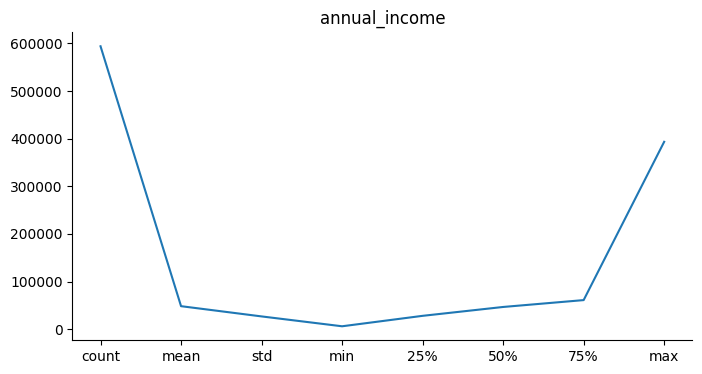

In [ ]:
from matplotlib import pyplot as plt
_df_8['annual_income'].plot(kind='line', figsize=(8, 4), title='annual_income')
plt.gca().spines[['top', 'right']].set_visible(False)